In [1]:
import pandas as pd
import numpy as np
import os

# --- File Paths ---
BASE_DIR = '/kaggle/input/cafa-6-protein-function-prediction'
TRAIN_DIR = os.path.join(BASE_DIR, 'Train')
TRAIN_TERMS_PATH = os.path.join(TRAIN_DIR, 'train_terms.tsv')
TRAIN_SEQUENCES_PATH = os.path.join(TRAIN_DIR, 'train_sequences.fasta') #fasta file for the protenis DAG stored man!!


In [2]:
#  How many unique proteins are in `train_terms.tsv`?

train_terms_df = pd.read_csv(TRAIN_TERMS_PATH, sep='\t')
print(len(train_terms_df)) # 537027
print(train_terms_df.head(10))
print("-" * 50)

# 1. How many unique proteins are there?
num_unique_proteins = train_terms_df['EntryID'].nunique()
print(f"1. There are {num_unique_proteins:,} unique proteins in the training set.")
print("-" * 50)

# 2. How many unique GO term labels are there?
num_unique_go_terms = train_terms_df['term'].nunique()
print(f"2. There are {num_unique_go_terms:,} unique GO term labels.")
print("-" * 50)
# 3. What are the three 'aspects' and how are they distributed?
aspect_distribution = train_terms_df['aspect'].value_counts()
print("\n3. The three sub-ontologies (aspects) are:")
print(aspect_distribution)
print("\n   P = Biological Process")
print("   F = Molecular Function")
print("   C = Cellular Component")
print("-" * 50)

537027
  EntryID        term aspect
0  Q5W0B1  GO:0000785      C
1  Q5W0B1  GO:0004842      F
2  Q5W0B1  GO:0051865      P
3  Q5W0B1  GO:0006275      P
4  Q5W0B1  GO:0006513      P
5  Q5W0B1  GO:0003682      F
6  Q5W0B1  GO:0005515      F
7  Q3EC77  GO:0000138      C
8  Q3EC77  GO:0005794      C
9  Q8IZR5  GO:0005515      F
--------------------------------------------------
1. There are 82,404 unique proteins in the training set.
--------------------------------------------------
2. There are 26,125 unique GO term labels.
--------------------------------------------------

3. The three sub-ontologies (aspects) are:
aspect
P    250805
C    157770
F    128452
Name: count, dtype: int64

   P = Biological Process
   F = Molecular Function
   C = Cellular Component
--------------------------------------------------


--- Analyzing Protein and Term Frequencies ---
--------------------------------------------------
Analysis of functions per protein:
count    82404.000000
mean         6.517002
std          7.965655
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max        233.000000
Name: term, dtype: float64

Analysis of proteins per function (GO Term):
count    26125.000000
mean        20.556057
std        268.143836
min          1.000000
25%          2.000000
50%          4.000000
75%         12.000000
max      33713.000000
Name: EntryID, dtype: float64
--------------------------------------------------

Visualizing the distributions...


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


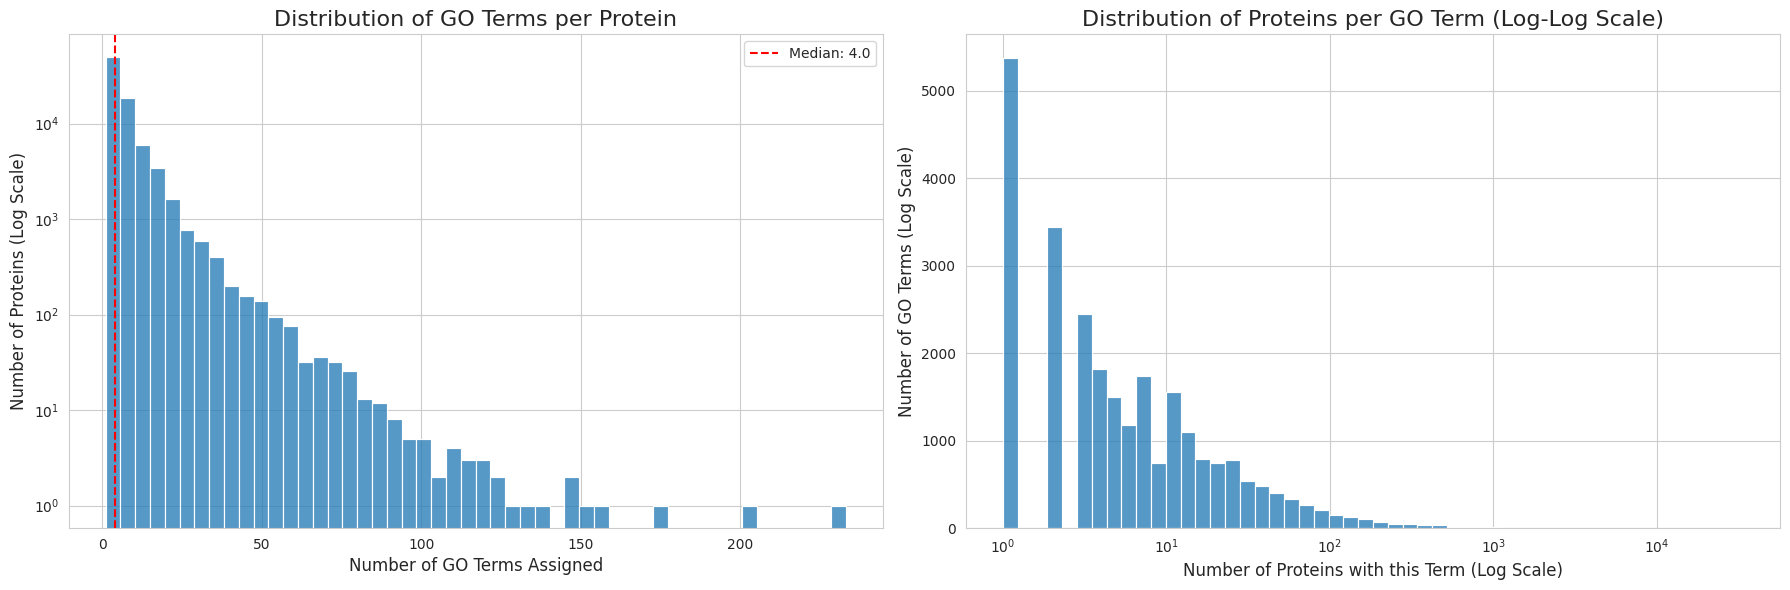

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style for better visuals
sns.set_style("whitegrid")

print("--- Analyzing Protein and Term Frequencies ---")
print("-" * 50)

# --- Question 1: How many functions does each protein have? ---
# We group by 'EntryID' and count the number of terms for each protein.
protein_function_counts = train_terms_df.groupby('EntryID')['term'].count()

print("Analysis of functions per protein:")
print(protein_function_counts.describe())

# --- Question 2: How many proteins have each function? ---
# We group by 'term' and count the number of proteins for each function.
term_protein_counts = train_terms_df.groupby('term')['EntryID'].count()

print("\nAnalysis of proteins per function (GO Term):")
print(term_protein_counts.describe())
print("-" * 50)


# --- Visualization ---
print("\nVisualizing the distributions...")

plt.figure(figsize=(18, 6))

# Plot for Question 1
plt.subplot(1, 2, 1)
sns.histplot(protein_function_counts, bins=50, log_scale=(False, True))
plt.title('Distribution of GO Terms per Protein', fontsize=16)
plt.xlabel('Number of GO Terms Assigned', fontsize=12)
plt.ylabel('Number of Proteins (Log Scale)', fontsize=12)
plt.axvline(protein_function_counts.median(), color='red', linestyle='--', label=f'Median: {protein_function_counts.median():.1f}')
plt.legend()


# Plot for Question 2
plt.subplot(1, 2, 2)
sns.histplot(term_protein_counts, bins=50, log_scale=True)
plt.title('Distribution of Proteins per GO Term (Log-Log Scale)', fontsize=16)
plt.xlabel('Number of Proteins with this Term (Log Scale)', fontsize=12)
plt.ylabel('Number of GO Terms (Log Scale)', fontsize=12)

plt.tight_layout()
plt.show()


In [4]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 34.3 MB/s eta 0:00:0000:0100:01


In [5]:
from Bio import SeqIO
from tqdm.notebook import tqdm
import pandas as pd

# We'll create lists to hold the data as we parse it
protein_ids = []
sequences = []

# Use tqdm for a progress bar, as this can take a moment
with open(TRAIN_SEQUENCES_PATH, 'r') as handle:
    for record in tqdm(SeqIO.parse(handle, "fasta"), total=82404): # total is the known number of proteins
        # The record.id looks like 'sp|Q5W0B1|...' - we want the middle part.
        protein_ids.append(record.id.split('|')[1])
        sequences.append(str(record.seq))

# Create a DataFrame from the parsed data
train_sequences_df = pd.DataFrame({'EntryID': protein_ids, 'Sequence': sequences})



  0%|          | 0/82404 [00:00<?, ?it/s]

In [6]:
print("\nSuccessfully parsed the FASTA file.")
print(f"Shape of the sequences DataFrame: {train_sequences_df.shape}")
print("Here are the first 5 rows:")
print(train_sequences_df.head())
print("-" * 50)


print("\n--- Merging Sequences with Labels ---")

# Now, we merge the two DataFrames on the 'EntryID' column
# An 'inner' merge ensures we only keep proteins that exist in BOTH files.
train_df = pd.merge(train_terms_df, train_sequences_df, on='EntryID', how='inner')

print("\nMerge complete.")
print(f"Shape of the final merged DataFrame: {train_df.shape}")
print("Sample of the final, unified dataset:")
print(train_df.head())
print("-" * 50)

# --- Final Sanity Check ---
num_proteins_in_merged = train_df['EntryID'].nunique()
print(f"Number of unique proteins in our final dataset: {num_proteins_in_merged}")
if num_proteins_in_merged == num_unique_proteins:
    print("Success! All proteins with labels also have a sequence.")
else:
    print("Warning: Some proteins were lost in the merge.")


Successfully parsed the FASTA file.
Shape of the sequences DataFrame: (82404, 2)
Here are the first 5 rows:
      EntryID                                           Sequence
0  A0A0C5B5G6                                   MRWQEMGYIFYPRKLR
1      A0JNW5  MAGIIKKQILKHLSRFTKNLSPDKINLSTLKGEGELKNLELDEEVL...
2      A0JP26  MVAEVCSMPAASAVKKPFDLRSKMGKWCHHRFPCCRGSGKSNMGTS...
3      A0PK11  MPGWFKKAWYGLASLLSFSSFILIIVALVVPHWLSGKILCQTGVDL...
4      A1A4S6  MGLQPLEFSDCYLDSPWFRERIRAHEAELERTNKFIKELIKDGKNL...
--------------------------------------------------

--- Merging Sequences with Labels ---

Merge complete.
Shape of the final merged DataFrame: (537027, 4)
Sample of the final, unified dataset:
  EntryID        term aspect  \
0  Q5W0B1  GO:0000785      C   
1  Q5W0B1  GO:0004842      F   
2  Q5W0B1  GO:0051865      P   
3  Q5W0B1  GO:0006275      P   
4  Q5W0B1  GO:0006513      P   

                                            Sequence  
0  MAQTVQNVTLSLTLPITCHICLGKVRQPVICINNHVFCSICIDLWL...  
1  M

In [7]:
train_df

,EntryID,term,aspect,Sequence
0,Q5W0B1,GO:0000785,C,MAQTVQNVTLSLTLPITCHICLGKVRQPVICINNHVFCSICIDLWL...
1,Q5W0B1,GO:0004842,F,MAQTVQNVTLSLTLPITCHICLGKVRQPVICINNHVFCSICIDLWL...
2,Q5W0B1,GO:0051865,P,MAQTVQNVTLSLTLPITCHICLGKVRQPVICINNHVFCSICIDLWL...
3,Q5W0B1,GO:0006275,P,MAQTVQNVTLSLTLPITCHICLGKVRQPVICINNHVFCSICIDLWL...
4,Q5W0B1,GO:0006513,P,MAQTVQNVTLSLTLPITCHICLGKVRQPVICINNHVFCSICIDLWL...
...,...,...,...,...
537022,Q06667,GO:0070481,P,MQVIGRGGANILIDYGDPTWLWRCCIRWPDLLSSNNSYTIKNISYI...
537023,B1NF19,GO:0033075,P,MEEKIMTNNSPWILTSSTTTTTTILLSLLFTIFIILRRNKSSSSKM...
537024,B1NF19,GO:0047052,F,MEEKIMTNNSPWILTSSTTTTTTILLSLLFTIFIILRRNKSSSSKM...
537025,B1NF19,GO:0047056,F,MEEKIMTNNSPWILTSSTTTTTTILLSLLFTIFIILRRNKSSSSKM...


# Issue
For a single protein like `Q5W0B1`, the sequence is repeated for every GO term it's associated with. This "long format" was excellent for our exploration, but to train a model, we need to transform it.

# Solution
We are prott5-embedding-for-cafa5, I am decide not to use create cafa-6 because it will take a lots of time to do so.

And we are going to follow som steps. 

1.  Load the pre-computed CAFA 5 embeddings and create a fast look-up map.
2.  Identify the top 1,500 most frequent GO terms from our `train_terms_df`.
3.  Iterate through our unique CAFA 6 proteins, find their corresponding embeddings, and build the final `X_train` and `Y_train` matrices simultaneously. This is a very efficient, one-pass approach.



In [8]:
import pandas as pd
import numpy as np
import os
import scipy.sparse as sp
from sklearn.preprocessing import MultiLabelBinarizer
import gc
from tqdm.auto import tqdm

# --- Step 1: Load Our CAFA 6 Ground Truth ---
# For clarity, let's group our labels by protein ID.
labels_by_protein = train_terms_df.groupby('EntryID')['term'].apply(list).to_dict()
all_cafa6_protein_ids = train_sequences_df['EntryID'].unique()
print(f"Our CAFA 6 dataset has {len(all_cafa6_protein_ids)} unique proteins.")
print("-" * 50)

# --- Step 2: Load the Pre-computed CAFA 5 Embeddings ---
EMBEDDING_DIR = '/kaggle/input/prott5-embedding-for-cafa5'
print(f"Loading pre-computed embeddings from {EMBEDDING_DIR}...")
cafa5_ids = np.load(os.path.join(EMBEDDING_DIR, 'train_ids.npy'))
cafa5_embeddings = np.load(os.path.join(EMBEDDING_DIR, 'train_embeddings.npy'))

# Create an efficient look-up map
embedding_map = {protein_id: embedding for protein_id, embedding in zip(cafa5_ids, cafa5_embeddings)}
print(f"Loaded {len(cafa5_ids)} embeddings and created look-up map.")
print("-" * 50)

# --- Step 3: Define Our Target Labels ---
N_LABELS = 1500
top_n_labels = train_terms_df['term'].value_counts().nlargest(N_LABELS).index.tolist()
print(f"Identified the top {N_LABELS} most frequent GO terms as our targets.")



Our CAFA 6 dataset has 82404 unique proteins.
--------------------------------------------------
Loading pre-computed embeddings from /kaggle/input/prott5-embedding-for-cafa5...
Loaded 142246 embeddings and created look-up map.
--------------------------------------------------
Identified the top 1500 most frequent GO terms as our targets.


In [9]:
import warnings
warnings.simplefilter("ignore")

# Use MultiLabelBinarizer for the transformation. It's the perfect tool.
mlb = MultiLabelBinarizer(classes=top_n_labels, sparse_output=True)
print("-" * 50)


# --- Step 4: Align and Build X_train and Y_train in One Pass ---
print("Aligning datasets and building final matrices...")
aligned_protein_ids = []
aligned_embeddings = []
aligned_labels = []

for protein_id in tqdm(all_cafa6_protein_ids, desc="Processing Proteins"):
    # Check if we have a pre-computed embedding for this protein
    if protein_id in embedding_map:
        aligned_protein_ids.append(protein_id)
        aligned_embeddings.append(embedding_map[protein_id])
        # Get the list of GO terms for this protein, or an empty list if none
        aligned_labels.append(labels_by_protein.get(protein_id, []))

# --- Create our final matrices ---
# X_train is our feature matrix (the embeddings)
X_train = np.array(aligned_embeddings)
# Y_train is our target matrix (the sparse, multi-hot encoded labels)
Y_train = mlb.fit_transform(aligned_labels)


print("\n--- FINAL MATRICES CREATED ---")
hit_rate = len(aligned_protein_ids) / len(all_cafa6_protein_ids)
print(f"Successfully found embeddings for {len(aligned_protein_ids)} proteins (Hit Rate: {hit_rate:.2%})")
print(f"Shape of feature matrix X_train: {X_train.shape}")
print(f"Shape of target matrix Y_train: {Y_train.shape}")
print("-" * 50)

# Clean up to save memory
del embedding_map, cafa5_ids, cafa5_embeddings, labels_by_protein, train_terms_df
gc.collect()

print("PREPROCESSING COMPLETE. We are ready to train our model.")

--------------------------------------------------
Aligning datasets and building final matrices...


Processing Proteins:   0%|          | 0/82404 [00:00<?, ?it/s]


--- FINAL MATRICES CREATED ---
Successfully found embeddings for 79268 proteins (Hit Rate: 96.19%)
Shape of feature matrix X_train: (79268, 1024)
Shape of target matrix Y_train: (79268, 1500)
--------------------------------------------------
PREPROCESSING COMPLETE. We are ready to train our model.


**Modeling - Step 1: Training the One-vs-Rest Classifiers**

**The Goal:** Train 1,500 individual `LogisticRegression` models, one for each of our target GO terms.

**The Strategy:** We will loop through each of our 1,500 labels. For each label, we will train a separate binary classifier using our powerful ProtT5 embeddings (`X_train`) as features and the single-label column (`Y_train[:, i]`) as the target. We will use `class_weight='balanced'` to counter the extreme class imbalance, and we will save the trained models to a file so we don't have to retrain them.

This code is the direct execution of the successful strategy we identified.


In [ ]:
from cuml.linear_model import LogisticRegression
from tqdm.auto import tqdm
import numpy as np
import pickle
import gc

# --- We assume X_train and Y_train are already loaded from the previous steps ---
print("--- STARTING GPU MODEL TRAINING ---")
print(f"Features (X_train) shape: {X_train.shape}")
print(f"Labels (Y_train) shape: {Y_train.shape}")
print("-" * 50)

# --- Initialize a dictionary for the GPU-trained models ---
trained_classifiers_gpu = {}

# cuML expects a dense array, and data types are important.
Y_train_dense = Y_train.toarray().astype(np.float32)
X_train_gpu = X_train.astype(np.float32)

# --- Loop through each GO term and train a GPU classifier ---
for i in tqdm(range(Y_train_dense.shape[1]), desc="Training GPU Classifiers"):
    go_term = mlb.classes_[i]
    y_target = Y_train_dense[:, i]
    
    if np.sum(y_target) < 5:
        trained_classifiers_gpu[go_term] = None
        continue
        
    # --- Define and train the cuML Logistic Regression model ---
    # NOTE: `class_weight` is NOT supported. This is our speed/performance trade-off.
    classifier_gpu = LogisticRegression(
        penalty='l2',
        C=1.0
    )
    
    classifier_gpu.fit(X_train_gpu, y_target)
    trained_classifiers_gpu[go_term] = classifier_gpu

print("\n--- GPU TRAINING COMPLETE ---")
num_trained = sum(1 for clf in trained_classifiers_gpu.values() if clf is not None)
print(f"Successfully trained {num_trained} binary classifiers on the GPU.")
print("-" * 50)

# --- Save our GPU-trained models ---
print("Saving trained models to file...")
with open('trained_classifiers_gpu.pkl', 'wb') as f:
    pickle.dump(trained_classifiers_gpu, f)
print("  - GPU-trained classifiers saved to 'trained_classifiers_gpu.pkl'")

with open('top_1500_mlb.pkl', 'wb') as f:
    pickle.dump(mlb, f)
print("  - Label binarizer (mlb) saved to 'top_1500_mlb.pkl'")
print("-" * 50)

# Final cleanup
del X_train, Y_train, Y_train_dense, X_train_gpu, trained_classifiers_gpu
gc.collect()

print("GPU MODEL TRAINING IS FINISHED.")

--- STARTING GPU MODEL TRAINING ---
Features (X_train) shape: (79268, 1024)
Labels (Y_train) shape: (79268, 1500)
--------------------------------------------------


Training GPU Classifiers:   0%|          | 0/1500 [00:00<?, ?it/s]

[2025-10-29 05:32:59.027] [CUML] [warning] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[2025-10-29 05:35:16.960] [CUML] [warning] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[2025-10-29 05:36:38.819] [CUML] [warning] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[2025-10-29 05:38:39.005] [CUML] [warning] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[2025-10-29 05:40:42.895] [CUML] [warning] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[2025-10-29 05:42:23.572] [CUML] [warning] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
